# **Import Necessary Libraries**

In [ ]:
import os
import platform
import time
import itertools
import glob as glob 

import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, average_precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers, Input, Model

# **Constants**

In [ ]:
PROJECT = 'Final'
START_TIME = time.strftime('%a_%d_%b_%Y_%H%M')

DATA_DIR = '/kaggle/input/data/'
CSV_PATH = '/kaggle/input/nih-cxr14-updated-csv/Data_Entry_2017_v2020.csv'
EXPERIMENT_PATH = f'/kaggle/working/{PROJECT}/experiments/'

DO_SUBSAMPLE = False
ONLY_PA = False
ONLY_M = False
ONLY_F = False

BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3

IMAGE_SIZE = (224, 224)
CHANNELS = 1
INPUT_SHAPE = IMAGE_SIZE + (CHANNELS,)

# **Load the base model**

In [ ]:
# https://keras.io/api/applications/densenet/
INPUT_TENSOR = Input(shape=INPUT_SHAPE, name='base_input')
base_model = tf.keras.applications.DenseNet121(weights='imagenet',
                                               input_tensor=INPUT_TENSOR,
                                               input_shape=INPUT_SHAPE,
                                               include_top=False)
base_model.trainable = False

## **Create directories**

In [40]:
EXPERIMENT_ID = f'{base_model.name}--TL--lr_{LEARNING_RATE}--batch_size_{BATCH_SIZE}--epochs_{EPOCHS}--{START_TIME}'
EXPERIMENT_SAVE_PATH = os.path.join(EXPERIMENT_PATH, EXPERIMENT_ID)

if not os.path.isdir(EXPERIMENT_SAVE_PATH):
    os.makedirs(EXPERIMENT_SAVE_PATH)
else:
    print('The directory already exists!')

try: 
  os.mkdir(os.path.join(EXPERIMENT_SAVE_PATH, 'reports'))
  os.mkdir(os.path.join(EXPERIMENT_SAVE_PATH, 'model'))
except OSError as error:
  print(error)

REPORTS_SAVE_PATH = os.path.join(EXPERIMENT_SAVE_PATH, 'reports')
MODEL_SAVE_PATH = os.path.join(EXPERIMENT_SAVE_PATH, 'model')

# **Data pipeline**

## **Read the data**

In [ ]:
df_all = pd.read_csv(CSV_PATH)
df_all = df_all.rename(columns={
                        'OriginalImagePixelSpacing[x': 'PixelSpacingX',
                        'y]': 'PixelSpacingY',
                        'OriginalImage[Width': 'Width',
                        'Height]': 'Height'
                        })

train_val_images = pd.read_csv(os.path.join(DATA_DIR, 'train_val_list.txt'), header=None, names=['Image Index'])
test_images =  pd.read_csv(os.path.join(DATA_DIR, 'test_list.txt'), header=None, names=['Image Index'])

unique_labels_all = sorted(list(set(itertools.chain.from_iterable(df_all['Finding Labels'].apply(lambda x : x.split('|')).values)))) 

one_hot_labels = pd.DataFrame(0.0, index=np.arange(len(df_all)), columns=unique_labels_all)

for index, row in df_all.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        one_hot_labels.loc[index, label] = 1.0
df_all = pd.concat([df_all, one_hot_labels], axis=1)
df_all.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Width,Height,PixelSpacingX,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df = df_all.copy()
unique_labels = unique_labels_all.copy()

In [43]:
############################################################################################################################################
############## Data cleaning: removing a defined list of labels, and the images with more than 3 pathologies ###############################
############################################################################################################################################

labels_to_remove = ['No Finding','Hernia','Pneumonia']
max_labels = 3

unique_labels = list(filter(lambda i: i not in labels_to_remove, unique_labels))
print(f'unique labels:\n{unique_labels}')
print(f'unique labels all:\n{unique_labels_all}')

NUM_LABELS = len(unique_labels)

df = df[df[labels_to_remove].sum(axis=1) == 0.0]
df = df[df[unique_labels].sum(axis=1) <= max_labels]
print(f'\ntotal num of images for each label:\n{df[unique_labels].sum(axis=0)}')
print(f'\ntotal num of data:\n{df[unique_labels].sum(axis=0).sum()}')

unique labels:
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']
unique labels all:
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

total num of images for each label:
Atelectasis           10347.0
Cardiomegaly           2465.0
Consolidation          3987.0
Edema                  1797.0
Effusion              11915.0
Emphysema              2249.0
Fibrosis               1563.0
Infiltration          18260.0
Mass                   5089.0
Nodule                 5779.0
Pleural_Thickening     2909.0
Pneumothorax           4860.0
dtype: float64

total num of data:
71220.0


In [10]:
df.loc[:, 'Finding Labels'] = df['Finding Labels'].str.replace('|', ',')
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Width,Height,PixelSpacingX,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,"Cardiomegaly,Emphysema",1,1,58,M,PA,2894,2729,0.143000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,"Cardiomegaly,Effusion",2,1,58,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,00000004_000.png,"Mass,Nodule",0,4,82,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
19,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112096,00030786_007.png,"Consolidation,Pleural_Thickening",6,30786,61,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
112097,00030786_006.png,Consolidation,7,30786,61,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112100,00030789_000.png,Infiltration,0,30789,51,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
112106,00030793_000.png,"Mass,Nodule",0,30793,57,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#####################################################################################################################################
############## Seperating labels and sampling as balanced as possible, concatenating and shuffling the final df #####################
#####################################################################################################################################
    
DO_SUBSAMPLE = True

# labels_to_subsample = ['No Finding']
df_dict = {}
# sample_size = 2*TRAIN_SIZE//NUM_LABELS
sample_size = 3000

print(f'try to take {sample_size} samples from each lable')
for label in unique_labels:
    try:
        df_dict[label] = df[df[label] == 1].sample(sample_size)
    except:
        print(f'take the whole {label}')
        df_dict[label] = df[df[label] == 1] # if there are less than 'sample size' images for a lable, take the whole

balanced_df = pd.concat(df_dict.values(), axis=0).sample(frac=1).reset_index(drop=True)
print(balanced_df[unique_labels].sum(axis=0))
print(f'\ntotal num of data in the new df: {len(balanced_df)}')

try to take 3000 samples from each lable
Atelectasis            8718.0
Cardiomegaly           5427.0
Consolidation          7206.0
Edema                  5226.0
Effusion              11099.0
Emphysema              6100.0
Fibrosis               5328.0
Infiltration          11001.0
Mass                   7537.0
Nodule                 7326.0
Pleural_Thickening     7255.0
Pneumothorax           7353.0
dtype: float64

total num of data in the new df: 36000


In [65]:
if DO_SUBSAMPLE:
    df = balanced_df
DO_SUBSAMPLE

True

In [ ]:
#######################################################################
############## creating train, val, and test dfs ######################
#######################################################################
    
train_val_df = df[df['Image Index'].isin(train_val_images['Image Index'])] 
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=1) 
test_df = df[df['Image Index'].isin(test_images['Image Index'])]

print(f'num of total images:\ntrain={len(train_df)}, val={len(val_df)}, test={len(test_df)}')
print(f'num of unique patients:\ntrain={len(train_df["Patient ID"].unique())}, val={len(val_df["Patient ID"].unique())}, test={len(test_df["Patient ID"].unique())}')

num of total images:
train=19552, val=2173, test=14275
num of unique patients:
train=4010, val=1372, test=961


In [67]:
############### checking duplicate subjects in train_val and test sets #################

train_val_subjects = set(train_val_df["Patient ID"].values)
test_subjects  = set(test_df["Patient ID"].values)
subject_leak = train_val_subjects.intersection(test_subjects)
print(f'There are {len(subject_leak)} common subjects in train_val and test sets!')

train_val_subject_leak = set(train_df["Patient ID"].values).intersection(set(val_df["Patient ID"].values))
print(f'There are {len(train_val_subject_leak)} common subjects in train and val sets!')

There are 0 common subjects in train_val and test sets!
There are 1229 common subjects in train and val sets!


In [69]:
print(train_df[unique_labels].sum(axis=0))
print(f'\ntotal num of data in the new df: {len(train_df)}')

Atelectasis           5111.0
Cardiomegaly          2677.0
Consolidation         3754.0
Edema                 2733.0
Effusion              6193.0
Emphysema             2730.0
Fibrosis              3216.0
Infiltration          6110.0
Mass                  4142.0
Nodule                4313.0
Pleural_Thickening    4054.0
Pneumothorax          2877.0
dtype: float64

total num of data in the new df: 19552


In [70]:
print(val_df[unique_labels].sum(axis=0))
print(f'\ntotal num of data in the new df: {len(val_df)}')

Atelectasis           581.0
Cardiomegaly          278.0
Consolidation         410.0
Edema                 304.0
Effusion              667.0
Emphysema             300.0
Fibrosis              372.0
Infiltration          698.0
Mass                  427.0
Nodule                456.0
Pleural_Thickening    450.0
Pneumothorax          330.0
dtype: float64

total num of data in the new df: 2173


In [71]:
print(test_df[unique_labels].sum(axis=0))
print(f'\ntotal num of data in the new df: {len(test_df)}')

Atelectasis           3026.0
Cardiomegaly          2472.0
Consolidation         3042.0
Edema                 2189.0
Effusion              4239.0
Emphysema             3070.0
Fibrosis              1740.0
Infiltration          4193.0
Mass                  2968.0
Nodule                2557.0
Pleural_Thickening    2751.0
Pneumothorax          4146.0
dtype: float64

total num of data in the new df: 14275


In [72]:
import numpy as np


def get_class_weights(total_counts, class_positive_counts, multiply):
    """
    Calculate class_weight used in training

    Arguments:
    total_counts - int
    class_positive_counts - dict of int, ex: {"Effusion": 300, "Infiltration": 500 ...}
    multiply - int, positve weighting multiply
    use_class_balancing - boolean 

    Returns:
    class_weight - dict of dict, ex: {"Effusion": { 0: 0.01, 1: 0.99 }, ... }
    """
    def get_single_class_weight(pos_counts, total_counts):
        denominator = (total_counts - pos_counts) * multiply + pos_counts
        return {
            0: pos_counts / denominator,
            1: (denominator - pos_counts) / denominator,
        }

    class_names = list(class_positive_counts.keys())
    label_counts = np.array(list(class_positive_counts.values()))
    class_weights_list = []
    for i, class_name in enumerate(class_names):
        class_weights_list.append(get_single_class_weight(label_counts[i], total_counts))
    class_weights = {cn: cw for cn, cw in zip(class_names, class_weights_list)}
    return class_weights

In [73]:
class_positive_counts = train_df[unique_labels].sum(axis=0).to_dict()
print(f'num of sampled images for each label:\n{class_positive_counts}')
total_counts = len(train_df)
class_weights = get_class_weights(total_counts, class_positive_counts, multiply=1)

print(f'{20*"-"}')
print(f'\nclass index:\n{class_idx}')
print(f'\nclass weights:\n{class_weights}')

num of sampled images for each label:
{'Atelectasis': 5111.0, 'Cardiomegaly': 2677.0, 'Consolidation': 3754.0, 'Edema': 2733.0, 'Effusion': 6193.0, 'Emphysema': 2730.0, 'Fibrosis': 3216.0, 'Infiltration': 6110.0, 'Mass': 4142.0, 'Nodule': 4313.0, 'Pleural_Thickening': 4054.0, 'Pneumothorax': 2877.0}
--------------------

class index:
[(0, 'Atelectasis'), (1, 'Cardiomegaly'), (2, 'Consolidation'), (3, 'Edema'), (4, 'Effusion'), (5, 'Emphysema'), (6, 'Fibrosis'), (7, 'Infiltration'), (8, 'Mass'), (9, 'Nodule'), (10, 'Pleural_Thickening'), (11, 'Pneumothorax')]

class weights:
{'Atelectasis': {0: 0.26140548281505727, 1: 0.7385945171849427}, 'Cardiomegaly': {0: 0.1369169394435352, 1: 0.8630830605564648}, 'Consolidation': {0: 0.19200081833060556, 1: 0.8079991816693944}, 'Edema': {0: 0.13978109656301146, 1: 0.8602189034369886}, 'Effusion': {0: 0.31674509001636664, 1: 0.6832549099836334}, 'Emphysema': {0: 0.13962765957446807, 1: 0.8603723404255319}, 'Fibrosis': {0: 0.16448445171849427, 1: 0.8

## **Data Sequence**

In [ ]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [108]:
data_augmentation = tf.keras.Sequential(
    name='aug',
    layers=[
        tf.keras.layers.RandomZoom(height_factor=(-0.05, 0.05), fill_mode='constant', name='zoom'),
    ])

## Image Pre-processing

In [109]:
class CXR14Sequence(tf.keras.utils.Sequence):
    def __init__(self, df, input_folder, batch_size=32, shuffle=True, preprocessing=True, augmentation=False, check_samples=False):
        self.df = df
        self.input_folder = input_folder
        self.batch_size = batch_size
        self.preprocessing = preprocessing
        self.augmentation = augmentation
#        CLAHE values based on 2023_High-precision multiclass classification of lung disease.pdf >>> clipLimit=3, tileGridSize=(10, 10)
        self.transform = cv.createCLAHE(clipLimit=3, tileGridSize=(10, 10))
        self.shuffle = shuffle
        self.check_samples = check_samples
        self.imagenet_mean = np.array([0.485, 0.456, 0.406])
        self.imagenet_std = np.array([0.229, 0.224, 0.225])
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def preprocess(self, image):
        image = np.array(image)
        gb_image = cv.GaussianBlur(image, (9, 9), 0)
        clahe_img = self.transform.apply(gb_image)
        clahe_img = cv.cvtColor(clahe_img, cv.COLOR_GRAY2RGB)
        clahe_img = self.min_max_normalize_sym_pos(clahe_img) # while not using tf.keras.applications.densenet.preprocess_input
        r_image = cv.resize(clahe_img, (224, 224))
        return r_image
    
    def augment_image(self, image):
        return data_augmentation(image)
    
    def min_max_normalize_sym(self, image: np.ndarray): # normalize image [-1, 1]
        return ((image - image.min()) / ((image.max() - image.min()) / 2)) - 1.0 
    
    def min_max_normalize_sym_pos(self, image: np.ndarray): # normalize image [0, 1]
        return (image - image.min()) / (image.max() - image.min())
    
    def standardize_image(self, image: np.ndarray): # standardize image [mean=0, variance=1]
        return (image - image.mean()) / image.std()
    
    def __getitem__(self, index):
        batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        for filename in batch['Image Index']:
            path = glob.glob(self.input_folder + '*/*/' + filename)[0]
            image = Image.open(path).convert('L')
            if self.preprocessing:
                image = self.preprocess(image)
            else: pass
            images.append(image)
        images = np.array(images)
        if self.augmentation:
                images = self.augment_image(images)
        else:
            pass
#         images = preprocess_input(images)
        images = tf.cast(images, dtype=tf.float32)
        if self.check_samples:
            return images, batch['Finding Labels']
        else:
            return images, np.array(batch[unique_labels].values)

## **Generators**

In [112]:
train_gen = CXR14Sequence(train_df, DATA_DIR, batch_size=BATCH_SIZE, shuffle=True, preprocessing=True, augmentation=True, check_samples=False)
val_gen = CXR14Sequence(val_df, DATA_DIR, batch_size=BATCH_SIZE, shuffle=True, preprocessing=True, augmentation=True, check_samples=False)
test_gen = CXR14Sequence(test_df, DATA_DIR, batch_size=BATCH_SIZE, shuffle=False, preprocessing=True, augmentation=False, check_samples=False)

### **Show sample from train data**

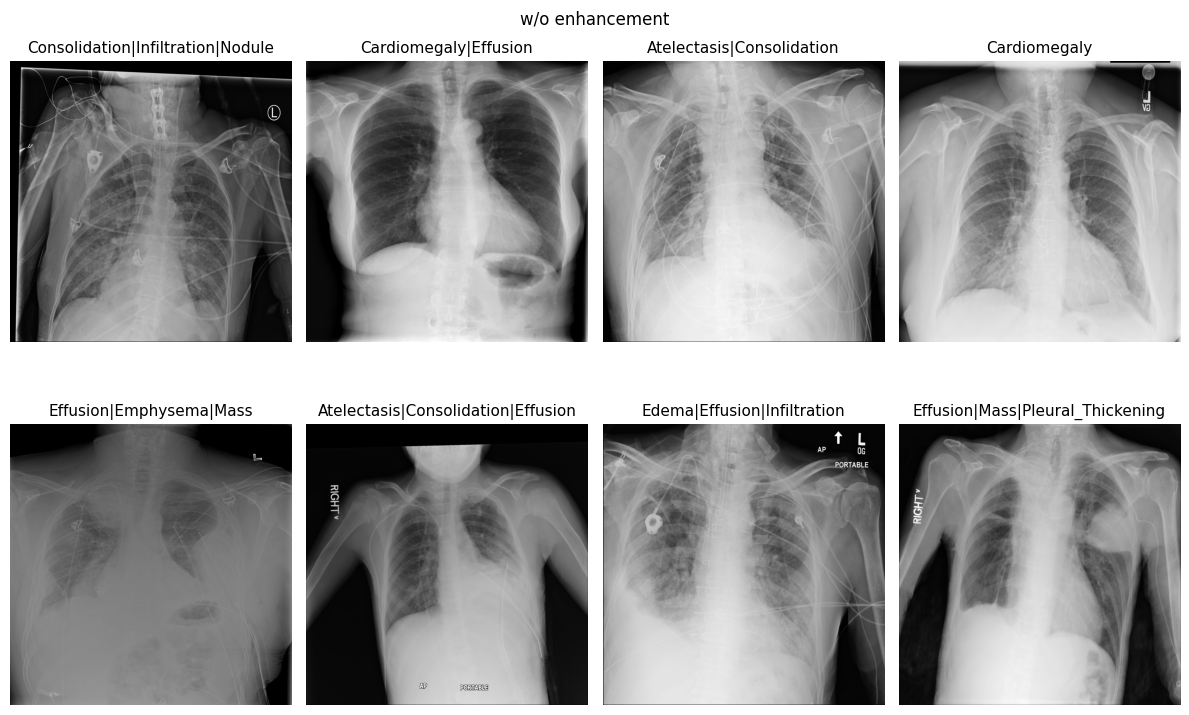

In [80]:
images, findings = CXR14Sequence(train_df, DATA_DIR, batch_size=8, preprocessing=False, augmentation=False, check_samples=True, shuffle=True).__getitem__(0)
fig = plt.figure(layout='tight', figsize=(12, 15))
fig.suptitle('w/o enhancement')
for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.title(findings.iloc[i], fontsize=11)
    plt.axis('off')
plt.show()

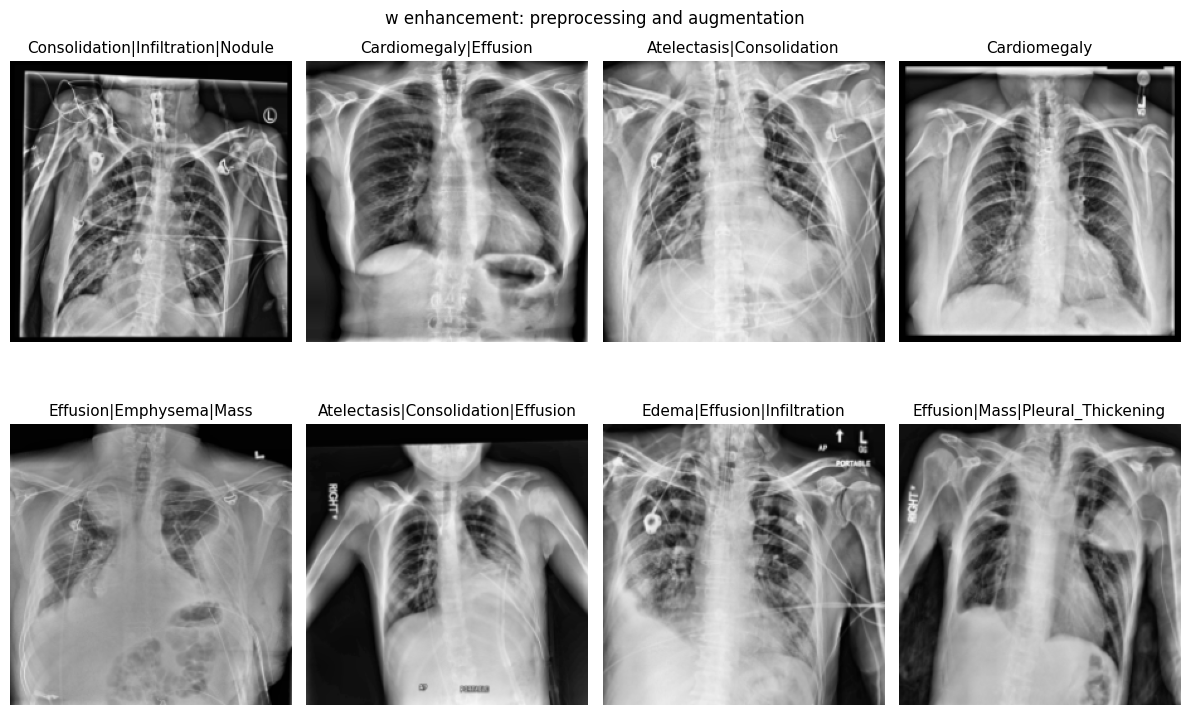

In [81]:
images, findings = CXR14Sequence(train_df, DATA_DIR, batch_size=8, preprocessing=True, augmentation=True, check_samples=True, shuffle=True).__getitem__(0)
fig = plt.figure(layout='tight', figsize=(12, 15))
fig.suptitle('w enhancement: preprocessing and augmentation')
for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.title(findings.iloc[i], fontsize=11)
    plt.axis('off')
plt.show()

# **Multi-label Cross Entropy**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow.keras.backend as K

class MultiLabelCrossEntropy:
    
    def __init__(self, labels: pd.DataFrame, epsilon=1e-7):
        self.epsilon = epsilon
        
        # Get the size of the data
        self.N = labels.shape[0]
        
        # Get the frequency occurrence for each class
        self.freq_pos = np.sum(labels == 1, axis=0) / self.N
        self.freq_neg = np.sum(labels == 0, axis=0) / self.N
        
        # Set the loss weights for each label
        self.pos_weights = self.freq_neg
        self.neg_weights = self.freq_pos
        
    def contribution(self):
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
    
    def contribution_imbalance(self):
        return self.freq_pos, self.freq_neg
        
    def loss(self, y_true, y_pred):
        # Convert Series to numpy arrays for positional indexing
        pos_weights_array = np.array(self.pos_weights)
        neg_weights_array = np.array(self.neg_weights)
        
        # Initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights_array)):
            loss += (-1 * K.mean(pos_weights_array[i] * y_true[:, i] * K.log(y_pred[:, i] + self.epsilon))) + \
                    (-1 * K.mean(neg_weights_array[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + self.epsilon)))
        
        return loss

In [111]:
pathology_labels = [label for label in unique_labels if label!='No Finding']
cross_entropy_loss = MultiLabelCrossEntropy(train_df[pathology_labels])
pos_contribution, neg_contribution = cross_entropy_loss.contribution()
pos_contribution_imb, neg_contribution_imb = cross_entropy_loss.contribution_imbalance()

# **Training Phase**

## **Create the model**

### **Add up layers and compile**

In [113]:
x = GlobalAveragePooling2D(name='top_gap2d')(base_model.output)
# x = BatchNormalization(name='top_bn')(x)
x = Dropout(0.3, name='dropout_1')(x)
x = Dense(256, activation='sigmoid', name='pred')(x)
x = Dropout(0.5, name='top_dropout')(x)
outputs = Dense(NUM_LABELS, activation='sigmoid', name='top_pred')(x)
model = Model(INPUT_TENSOR, outputs)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
#     loss=custom_weighted_bce,
    loss=cross_entropy_loss.loss,
#     loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.F1Score(average='weighted', threshold=0.5, name='f1_score'),
        tf.keras.metrics.AUC(multi_label=True, name='AUC'),
    ])

model.name = 'base_' + base_model.name
# model.summary(show_trainable=True)

### **Call-backs**

In [114]:
best_loss_weight_id=f'{base_model.name}--best_loss_weights_chkp--{START_TIME}.weights.h5'
best_auc_weight_id=f'{base_model.name}--best_auc_weights_chkp--{START_TIME}.weights.h5'

best_loss_model_id=f'{base_model.name}--best_loss_model_chkp--{START_TIME}.keras'
best_auc_model_id=f'{base_model.name}--best_auc_model_chkp--{START_TIME}.keras'

def lr_scheduler(epoch, lr):
    if epoch < (EPOCHS):
        return lr
    else:
        return lr * np.exp(-0.1)
    
best_loss_weight_ckpt = ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, best_loss_weight_id), 
                            monitor='val_loss', 
                            mode='min', 
                            save_best_only=True, 
                            save_weights_only=True, 
                            verbose=0)

best_loss_model_ckpt = ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, best_loss_model_id), 
                            monitor='val_loss', 
                            mode='min', 
                            save_best_only=True, 
                            save_weights_only=False, 
                            verbose=1)

best_auc_weight_ckpt = ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, best_auc_weight_id), 
                            monitor='val_AUC', 
                            mode='max', 
                            save_best_only=True, 
                            save_weights_only=True, 
                            verbose=0)

best_auc_model_ckpt = ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, best_auc_model_id), 
                            monitor='val_AUC', 
                            mode='max', 
                            save_best_only=True, 
                            save_weights_only=False, 
                            verbose=1)

early_stop = EarlyStopping(monitor="val_loss", 
                           mode="min", 
                           patience=10,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.9,
                              patience=1, 
                              min_lr=1e-8,
                              mode='min',
                              verbose=1)

schedule_lr = LearningRateScheduler(lr_scheduler, 
                                    verbose=1)

callbacks_list = [best_loss_weight_ckpt, best_loss_model_ckpt, best_auc_weight_ckpt, best_auc_model_ckpt, early_stop, reduce_lr]

### **Training**

In [115]:
history = model.fit(train_gen, 
                    epochs=EPOCHS, 
                    validation_data=val_gen, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    verbose=1)

# final_training_lr = model.optimizer.learning_rate.numpy()

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6114 - accuracy: 0.5733 - f1_score: 0.3689 - loss: 2.5962

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 2.66566, saving model to /kaggle/working/Final_1/experiments/densenet121--TL--lr_0.001--batch_size_32--epochs_20--Mon_05_Aug_2024_1127/model/densenet121--best_loss_model_chkp--Mon_05_Aug_2024_1127.keras

Epoch 1: val_AUC improved from -inf to 0.67294, saving model to /kaggle/working/Final_1/experiments/densenet121--TL--lr_0.001--batch_size_32--epochs_20--Mon_05_Aug_2024_1127/model/densenet121--best_auc_model_chkp--Mon_05_Aug_2024_1127.keras
611/611 ━━━━━━━━━━━━━━━━━━━━ 929s 1s/step - AUC: 0.6115 - accuracy: 0.5733 - f1_score: 0.3689 - loss: 2.5961 - val_AUC: 0.6729 - val_accuracy: 0.5423 - val_f1_score: 0.3117 - val_loss: 2.6657 - learning_rate: 0.0010
Epoch 2/20
611/611 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6935 - accuracy: 0.6339 - f1_score: 0.4288 - loss: 2.4034
Epoch 2: val_loss improved from 2.66566 to 2.38136, saving model to /kaggle/working/Final_1/experiments/densenet121--TL--lr_0.001--batch_size_32--epochs_20--Mon_05_Aug_2024_1127/mod

In [116]:
tr_epochs = len(history.history['loss'])

# **Training history**

In [117]:
print(f'total epochs: {tr_epochs}')

total epochs: 20


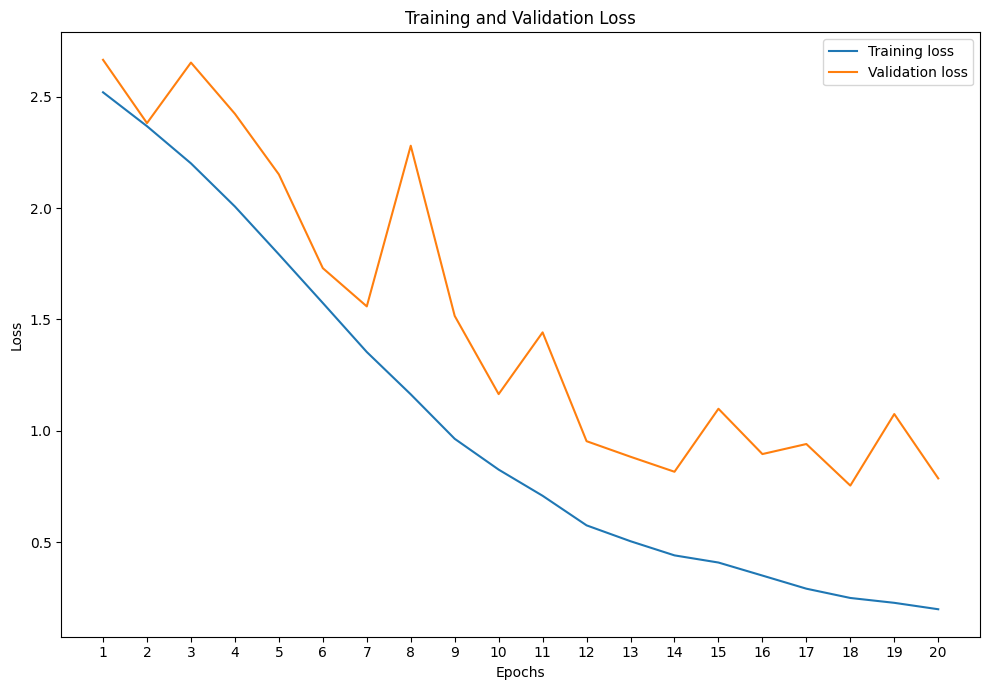

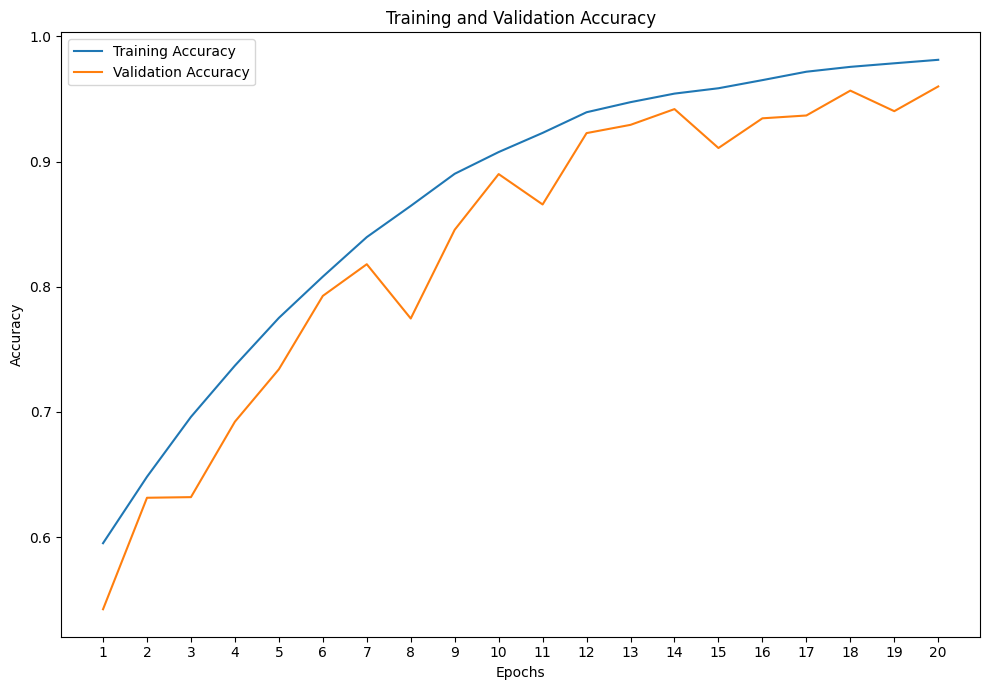

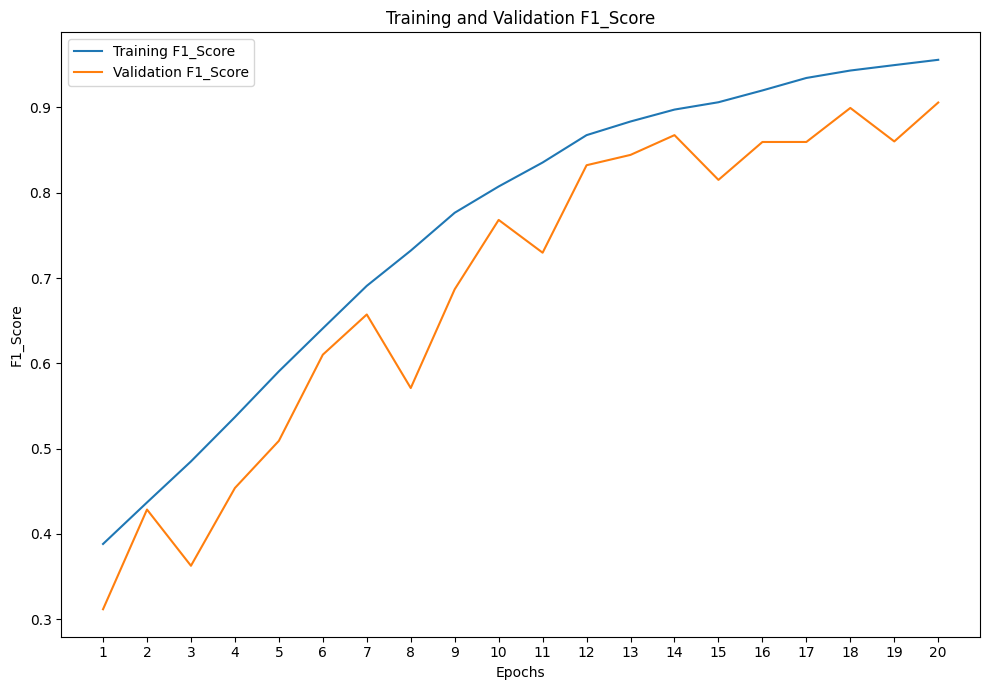

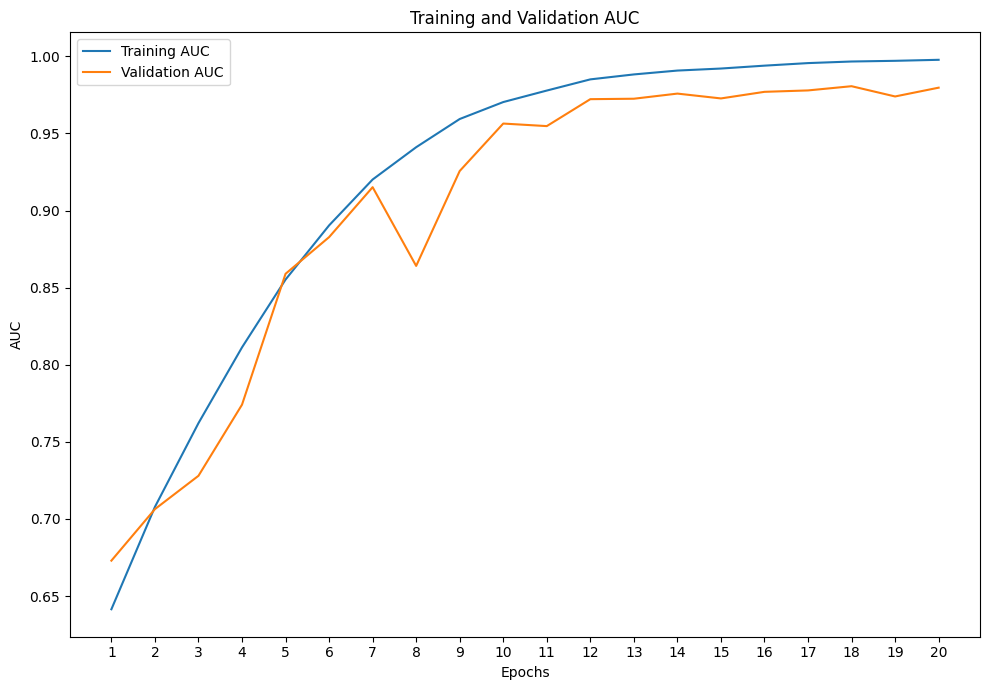

In [ ]:
tr_loss = history.history['loss']
tr_acc = history.history['accuracy']
tr_f1_score = history.history['f1_score']
tr_auc = history.history['AUC']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
val_f1_score = history.history['val_f1_score']
val_auc = history.history['val_AUC']

index_loss = np.argmin(val_loss)
loss_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_f1_score = np.argmax(val_f1_score)
f1_score_highest = val_f1_score[index_f1_score]

index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

loss_label = f'best epoch: {str(index_loss+1)}'
acc_label = f'best epoch: {str(index_acc+1)}'
f1_score_label = f'best epoch: {str(index_f1_score+1)}'
auc_label = f'best epoch: {str(index_auc+1)}'

plt.figure(figsize=(10, 7), layout='tight')

plt.subplot(1, 1, 1)
plt.xticks(np.arange(tr_epochs), np.arange(1, tr_epochs+1))
plt.plot(tr_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim()
plt.title(f'Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss curve new.png')
plt.show()


plt.figure(figsize=(10, 7), layout='tight')
plt.xticks(np.arange(tr_epochs), np.arange(1, tr_epochs+1))
plt.plot(tr_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim()
plt.title(f'Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy curve new.png')
plt.show()

plt.figure(figsize=(10, 7), layout='tight')
plt.xticks(np.arange(tr_epochs), np.arange(1, tr_epochs+1))
plt.plot(tr_f1_score, label='Training F1_Score')
plt.plot(val_f1_score, label='Validation F1_Score')
plt.ylim()
plt.title(f'Training and Validation F1_Score')
plt.xlabel('Epochs')
plt.ylabel('F1_Score')
plt.legend()
plt.savefig('f1_score new.png')
plt.show()

plt.figure(figsize=(10, 7), layout='tight')
plt.xticks(np.arange(tr_epochs), np.arange(1, tr_epochs+1))
plt.plot(tr_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')

plt.ylim()
plt.title(f'Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.savefig('auc score.png')
plt.show()


# **Evaluation**

In [120]:
train_score = model.evaluate(train_gen, verbose=1)
val_score = model.evaluate(val_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

611/611 ━━━━━━━━━━━━━━━━━━━━ 648s 1s/step - AUC: 0.9994 - accuracy: 0.9857 - f1_score: 0.9666 - loss: 0.1373
68/68 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - AUC: 0.9800 - accuracy: 0.9563 - f1_score: 0.8987 - loss: 0.7779


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


447/447 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - AUC: 0.6673 - accuracy: 0.7350 - f1_score: 0.3785 - loss: 7.1820


# **Model performance**

In [121]:
y_score = model.predict(test_gen)
try:
    roc_auc = roc_auc_score(test_df[unique_labels].values, y_score, average='weighted')
    print(f' Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores: {roc_auc:.4f}')
except Exception as e:
    roc_auc = 0.0
    print(f'>>> Exception: {e}')

447/447 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step
 Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores: 0.6782


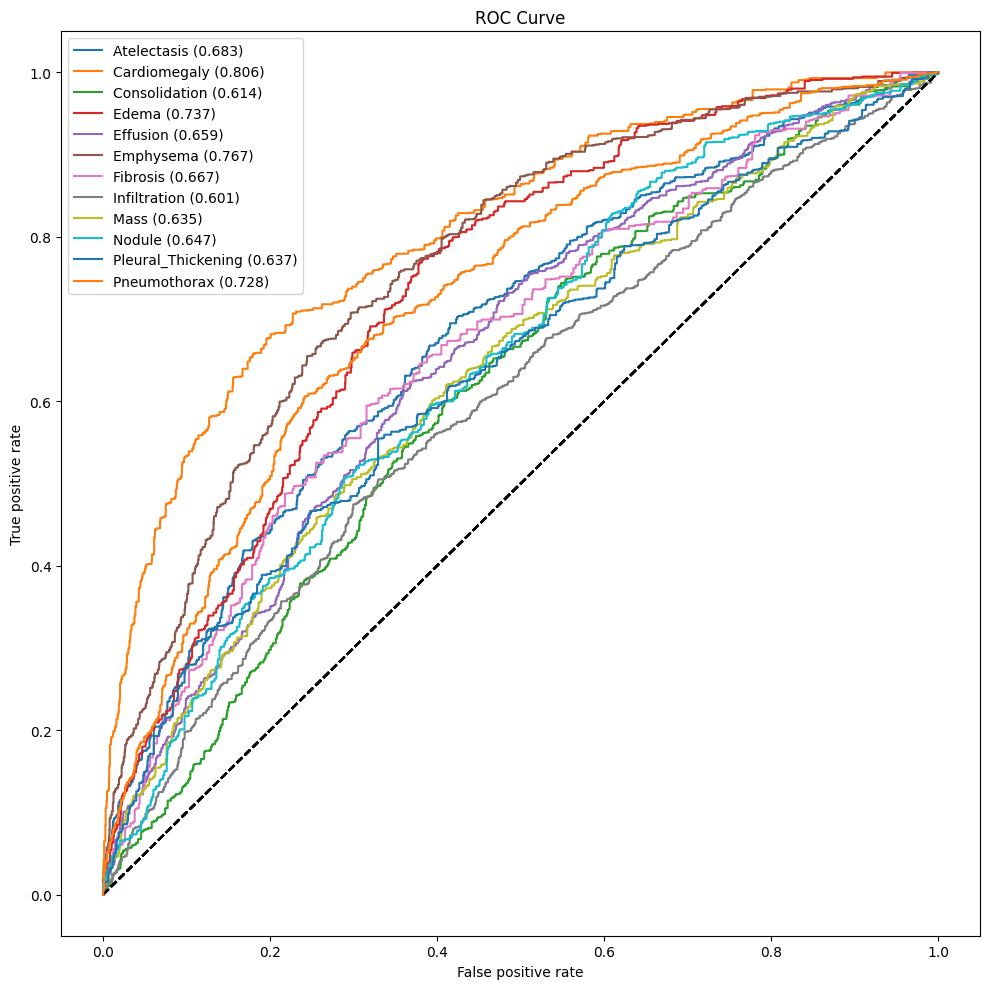

[0.6829531795937858,
 0.8064540938662131,
 0.6140994532581137,
 0.7373159669543541,
 0.658787294731653,
 0.7671657749347007,
 0.6674118903850826,
 0.600643681979483,
 0.6351899552003303,
 0.6471636314824527,
 0.6368874288999828,
 0.7281551821350217]

In [194]:
def get_roc_curve(labels, predicted_vals, real_vals, model_name, START_TIME):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = real_vals[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred, average='weighted')
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            
            plt.figure(1, layout='tight', figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC Curve')
            plt.legend(loc='best')
        except:
            print(
                f'Error in generating ROC curve for {labels[i]}.'
                f'Dataset lacks enough examples.'
            )
    fig_id = f'{model_name}-ROC-{START_TIME}.png'
    fig_save_path = os.path.join(REPORTS_SAVE_PATH, fig_id)
    plt.savefig(fig_save_path)
    
    plt.show()
    return auc_roc_vals

get_roc_curve(unique_labels, y_score, test_df[unique_labels].values, base_model.name, START_TIME)

## **Save the model**

In [196]:
# save model
model_save_id = f'{base_model.name}--tst_roc_auc_{roc_auc:.2f}--{START_TIME}.keras'
model_save_loc = os.path.join(MODEL_SAVE_PATH, model_save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# save h5 model
h5_save_id = f'{base_model.name}--tst_roc_auc_{roc_auc:.2f}--{START_TIME}.h5'
h5_save_loc = os.path.join(MODEL_SAVE_PATH, h5_save_id)
model.save(h5_save_loc)
print(f'model was saved as {h5_save_loc}')

# save weights
weight_save_id = f'{base_model.name}--tst_roc_auc_{roc_auc:.2f}--{START_TIME}.weights.h5'
weights_save_loc = os.path.join(MODEL_SAVE_PATH, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as /kaggle/working/Final_1/experiments/densenet121--TL--lr_0.001--batch_size_32--epochs_20--Mon_05_Aug_2024_1127/model/densenet121--tst_roc_auc_0.68--Mon_05_Aug_2024_1127.keras
model was saved as /kaggle/working/Final_1/experiments/densenet121--TL--lr_0.001--batch_size_32--epochs_20--Mon_05_Aug_2024_1127/model/densenet121--tst_roc_auc_0.68--Mon_05_Aug_2024_1127.h5
weights were saved as /kaggle/working/Final_1/experiments/densenet121--TL--lr_0.001--batch_size_32--epochs_20--Mon_05_Aug_2024_1127/model/densenet121--tst_roc_auc_0.68--Mon_05_Aug_2024_1127.weights.h5


In [ ]:
threshold = 0.5

y_pred = (y_score >= threshold).astype(int)
y_true = test_df[unique_labels].values.astype(int)
support = test_df[unique_labels].sum().astype(int) # num of data for each label in the test set

mcm = multilabel_confusion_matrix(y_true, y_pred)
TN = mcm[:, 0, 0]
TP = mcm[:, 1, 1]
FN = mcm[:, 1, 0]
FP = mcm[:, 0, 1]

epsilon = 1e-11
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN+epsilon)
# Specificity or true negative rate
TNR = TN/(TN+FP+epsilon) 
# Precision or positive predictive value
PPV = TP/(TP+FP+epsilon)
# Fall out or false positive rate
FPR = FP/(FP+TN+epsilon)
# False negative rate
FNR = FN/(TP+FN+epsilon)
# Negative predictive value
NPV = TN/(TN+FN+epsilon)
# False discovery rate
FDR = FP/(TP+FP+epsilon)

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)

f1_score = (PPV*TPR)/(PPV+TPR+epsilon)

metrics_dict = {'Accuracy': accuracy,
                'Precision (PPV)': PPV, 
                'Recall (TPR)': TPR,
                'F1_Score': f1_score,
                'Specificity (TNR)': TNR, 
                'FPR': FPR, 
                'FNR': FNR,
                'Support': support
               }


report_id = f'{base_model.name}-classification_report-{START_TIME}.csv'
report_save_path = os.path.join(REPORTS_SAVE_PATH, report_id)

cl_report_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=unique_labels).transpose()

cl_report_df

,Accuracy,Precision (PPV),Recall (TPR),F1_Score,Specificity (TNR),FPR,FNR,Support
Atelectasis,0.768757,0.430238,0.280238,0.169702,0.900169,0.099831,0.719762,3026.0
Cardiomegaly,0.847916,0.578672,0.447816,0.252452,0.931712,0.068288,0.552184,2472.0
Consolidation,0.727916,0.271939,0.165023,0.102700,0.880353,0.119647,0.834977,3042.0
Edema,0.746410,0.294809,0.469621,0.181113,0.796541,0.203459,0.530379,2189.0
Effusion,0.628371,0.416221,0.624676,0.249788,0.629932,0.370068,0.375324,4239.0
Emphysema,0.791944,0.532258,0.268730,0.178571,0.935297,0.064703,0.731270,3070.0
Fibrosis,0.849247,0.279443,0.150000,0.097607,0.946310,0.053690,0.850000,1740.0
Infiltration,0.533310,0.346207,0.662771,0.227414,0.479468,0.520532,0.337229,4193.0
Mass,0.699615,0.324561,0.411388,0.181426,0.775272,0.224728,0.588612,2968.0
Nodule,0.708932,0.279404,0.395776,0.163781,0.777266,0.222734,0.604224,2557.0


In [ ]:
f, axes = plt.subplots(1, NUM_LABELS, figsize=(NUM_LABELS*5, 5))
axes = axes.ravel().tolist()
for i in range(NUM_LABELS):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i],
                                                   y_pred[:, i]))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'{unique_labels[i]}')

f.tight_layout()

fig_id = f'{base_model.name}-conf_mat-{START_TIME}.png'
fig_save_path = os.path.join(REPORTS_SAVE_PATH, fig_id)
plt.savefig(fig_save_path)

plt.show()

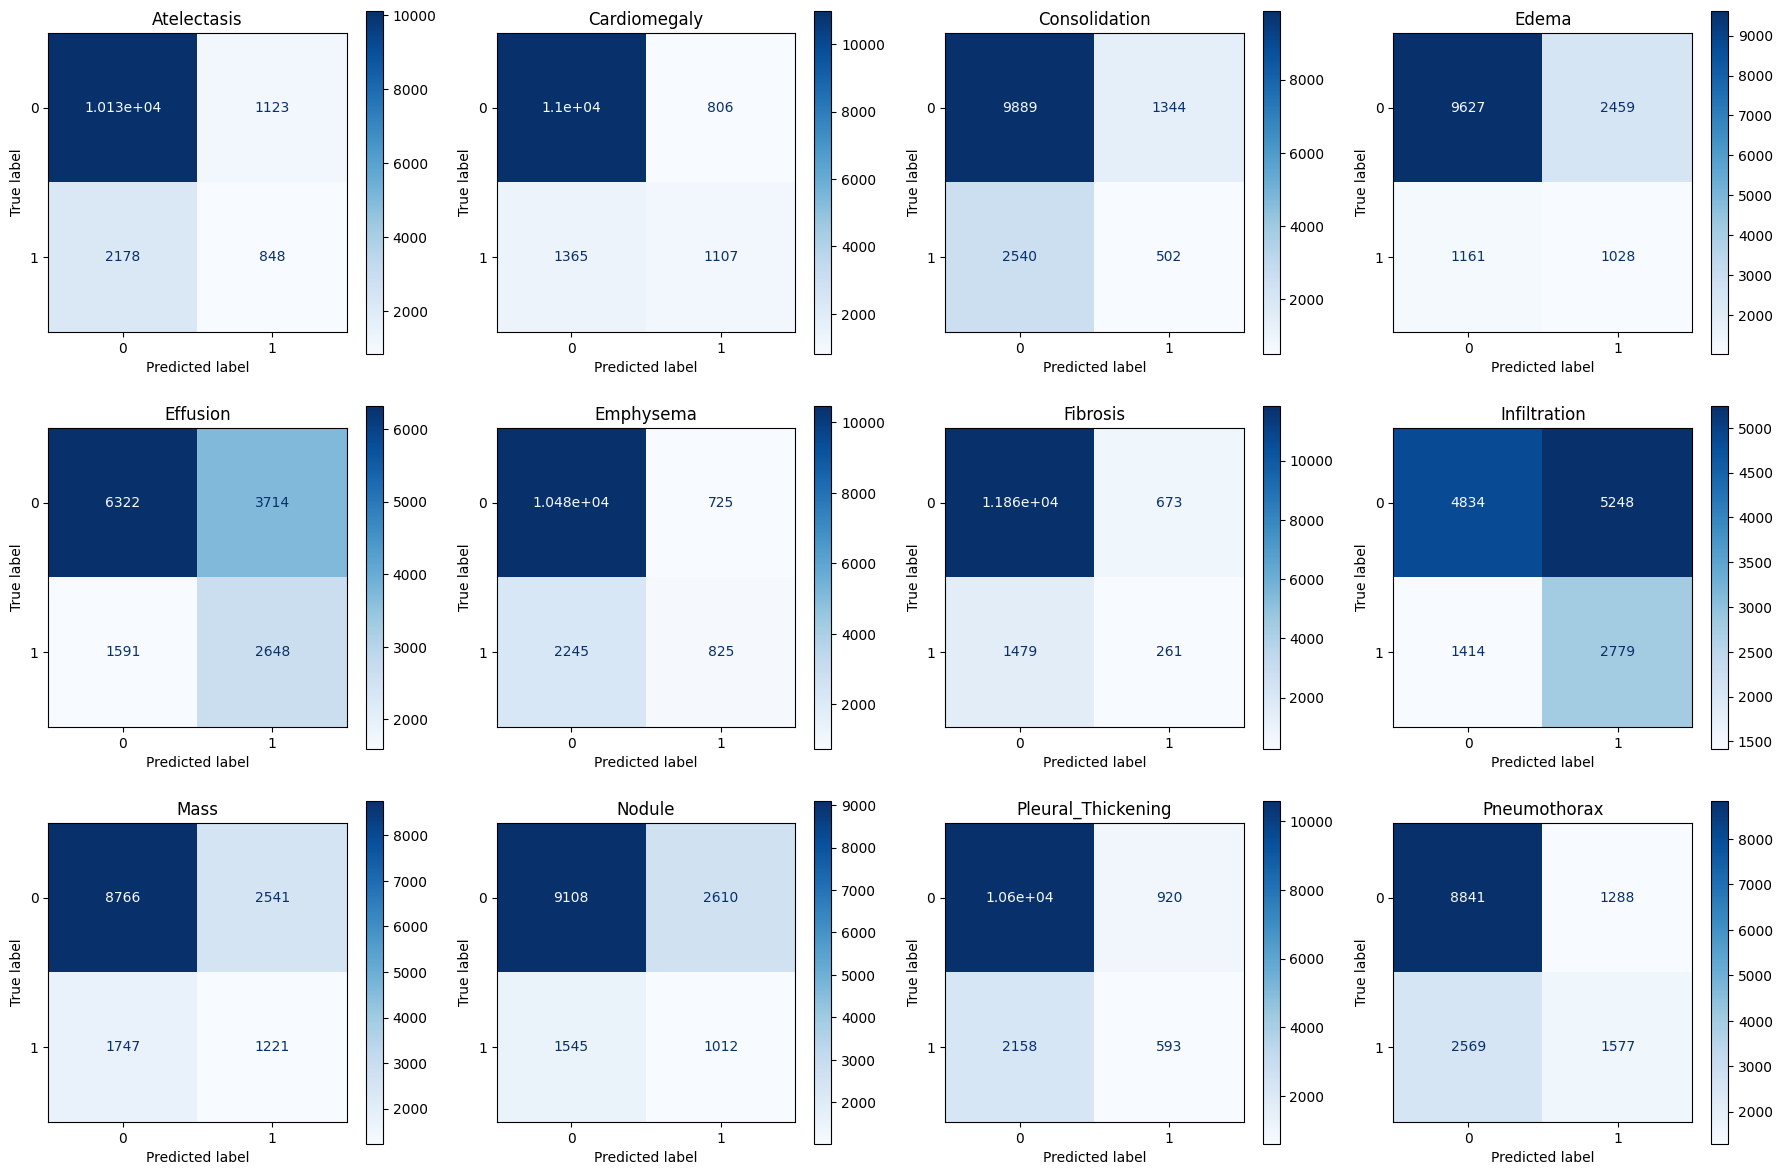

In [212]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Number of labels
NUM_LABELS = len(unique_labels)  # Update this as needed

# Calculate number of rows needed (2 confusion matrices per row)
num_rows = int(np.ceil(NUM_LABELS / 4))

# Create subplots with 2 confusion matrices per row
f, axes = plt.subplots(num_rows, 4, figsize=(18, 4 * num_rows))

# Flatten axes array for easy indexing
axes = axes.ravel()

# Plot each confusion matrix
for i in range(NUM_LABELS):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]))
    disp.plot(ax=axes[i], values_format='.4g', cmap='Blues')
    axes[i].set_title(f'{unique_labels[i]}')

# Hide any unused subplots if NUM_LABELS is not a multiple of 2
for j in range(NUM_LABELS, len(axes)):
    axes[j].axis('off')

f.tight_layout()

# Save figure
fig_id = f'{base_model.name}-conf_mat-{START_TIME}.png'
fig_save_path = os.path.join(REPORTS_SAVE_PATH, fig_id)
plt.savefig('confusion matrix.png')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


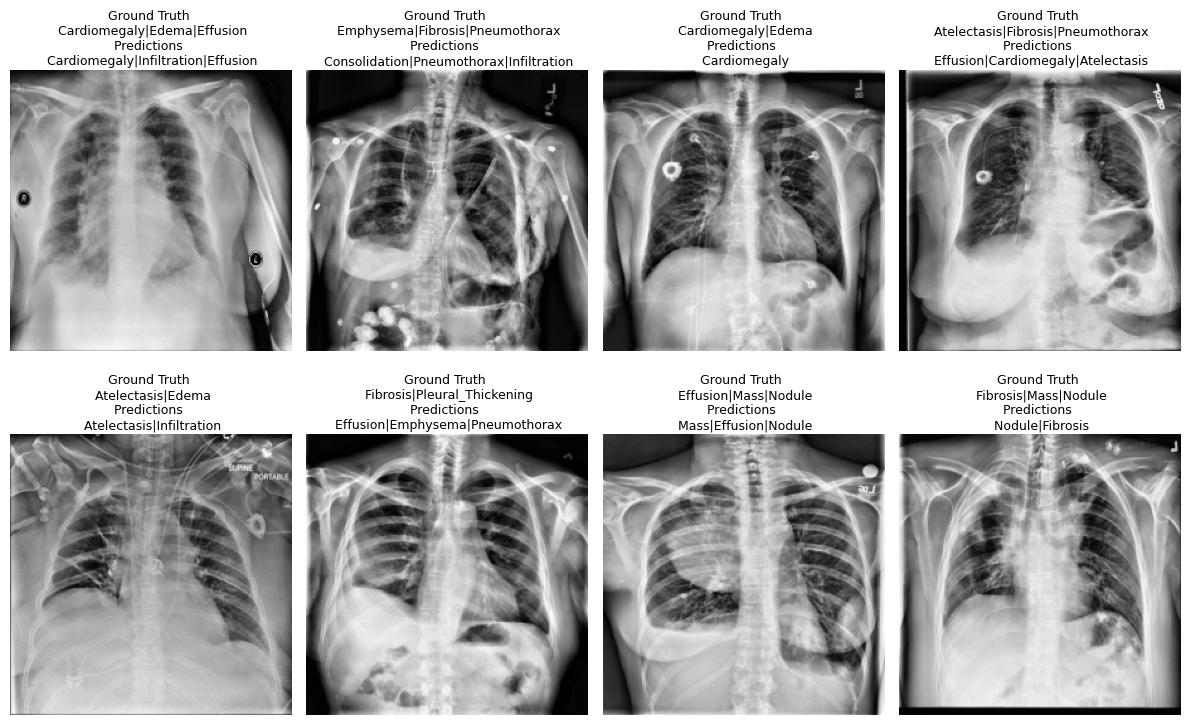

In [210]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Retrieve a batch of images and their findings
images, findings = CXR14Sequence(test_df[120:128], DATA_DIR, batch_size=8, preprocessing=True, augmentation=False, check_samples=True, shuffle=True).__getitem__(0)

# Predict the labels for the batch of images
predictions = model.predict(images)

# Define class labels (make sure this aligns with your model's output labels)
class_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
                 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 
                 'Nodule', 'Pleural_Thickening', 'Pneumothorax']

# Create the plot
fig = plt.figure(layout='tight', figsize=(12, 15))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    
    # Display the image
    image = images[i]
    plt.imshow(image)
    
    # Get the prediction probabilities
    prediction = predictions[i]
    
    # Find the top 3 predictions with probability greater than 0.5
    top_predictions = [(label, prob) for label, prob in zip(class_labels, prediction) if prob > 0.5]
    top_predictions = sorted(top_predictions, key=lambda x: x[1], reverse=True)[:3]
    
    # Format the label and probabilities for display
    title = f'Ground Truth \n {findings.iloc[i]}\n'
    if top_predictions:
        predictions_str = '|'.join([f"{label}" for label, prob in top_predictions])
        title += f'Predictions \n {predictions_str}'
    else:
        title += ""

    # Set title and hide axis
    plt.title(title, fontsize=9, loc='center', pad=4)
    plt.axis('off')

# Show the plot
plt.savefig('predictions.png')
plt.show()

In [ ]:
import os
import zipfile

# Define the directory to zip and the output zip file name
directory_to_zip = '/kaggle/working/Final'
zip_file_name = '/kaggle/working/final.zip'

# Create a zip file
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through all files and directories in the specified directory
    for root, dirs, files in os.walk(directory_to_zip):
        for file in files:
            # Create the full file path
            file_path = os.path.join(root, file)
            # Add file to the zip file
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

print(f"All files in '{directory_to_zip}' have been zipped into '{zip_file_name}'")